This sample involves the evaluation of Bayesian modelling methods on a real multivariate regression task. The guiding objectives are to derive a good predictor for data derived from an “energy efficiency” data set, and to estimate which of the input variables are relevant for prediction.

In particular, the exercise focuses on approximating (and averaging over) posterior distributions using the **Hamiltonian Monte Carlo**  stochastic method.

In [411]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import seaborn as sns

import lab4_hmc as hmc

## Load Data

The **“Energy efficiency”** data set, originally from the University of Oxford, and now made available at the popular UCI repository:

- https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

This multivariate data set contains 768 examples and comprises eight input variables 𝑥1, ... , 𝑥8 reprsenting some basic architectural parameters for buildings (e.g. “Roof Area” and “Glazing Area”) with the intention of predicting a ninth variable, the required **“Heating Load”**. This can be considered a real-value variable, suitable for standard regression modelling (with the usual Gaussian noise model).

The data has been pre-processed and split into two specific data sets for analysis:

* Trainingset: ee-train.csv
* Testset: ee-test.csv

In [2]:
train = pd.read_csv('ee-train.csv')
test = pd.read_csv('ee-test.csv')

In [3]:
train.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.62,808.5,367.5,220.5,3.5,3,0.10,5,12.74
1,0.90,563.5,318.5,122.5,7.0,3,0.10,2,29.68
2,0.90,563.5,318.5,122.5,7.0,3,0.40,2,36.57
3,0.79,637.0,343.0,147.0,7.0,2,0.25,2,38.57
4,0.90,563.5,318.5,122.5,7.0,4,0.40,5,34.72


In [4]:
train.shape

(384, 9)

The principal objectives are focused on the predictive modelling of the energy efficiency data and take the form of a series of largely sequential sub-tasks. 

# Task 1 - Exploratory Analysis

Undertake an initial exploratory analysis of the training data and summarise

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


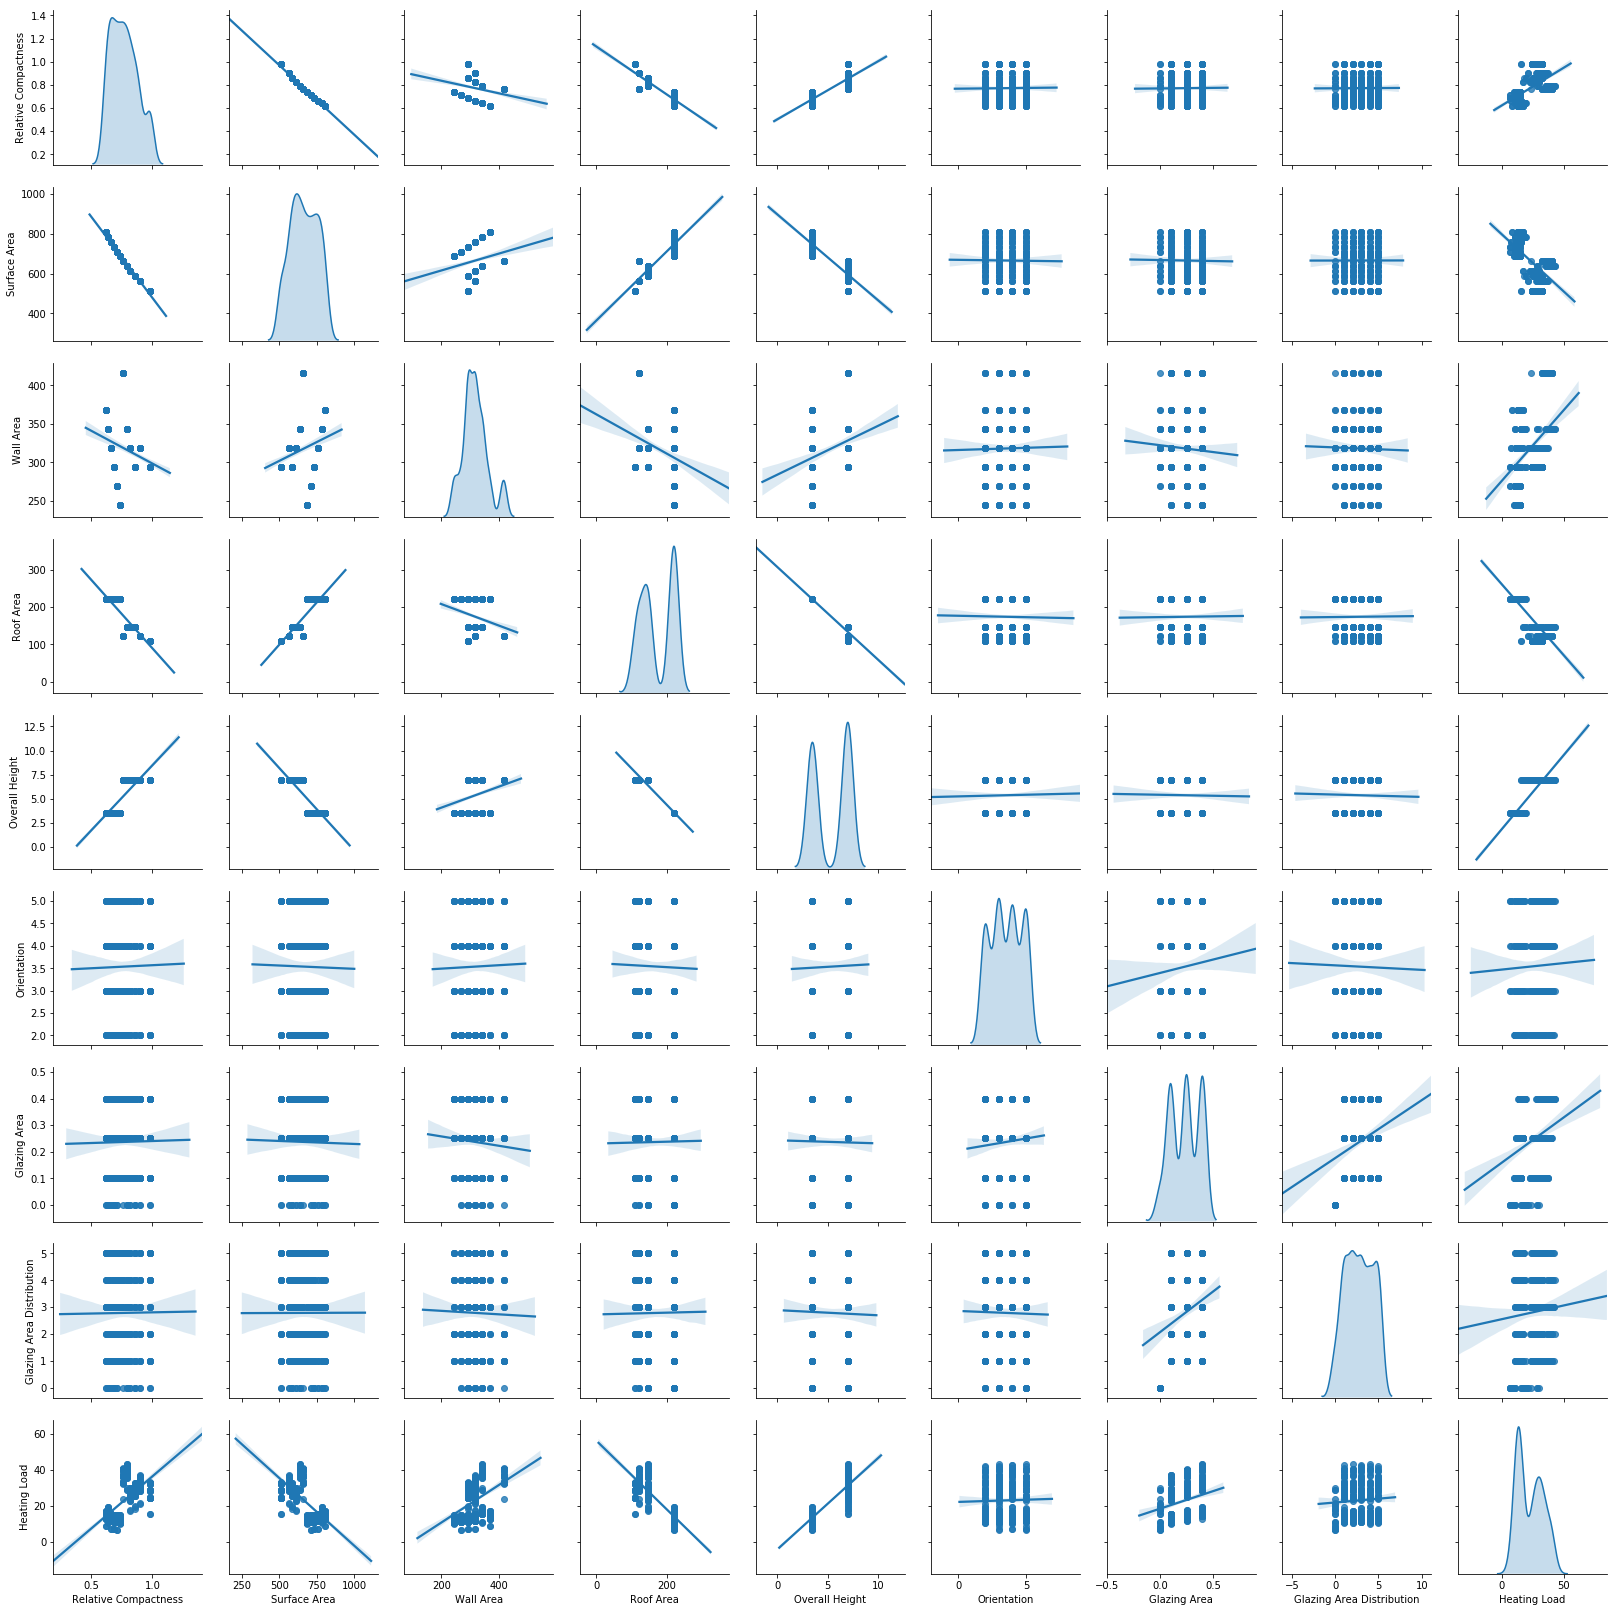

In [635]:
sns.pairplot(train, kind="reg",palette="Set2", diag_kind="kde", size=2.5)
plt.savefig("linea relavant matrix.png")

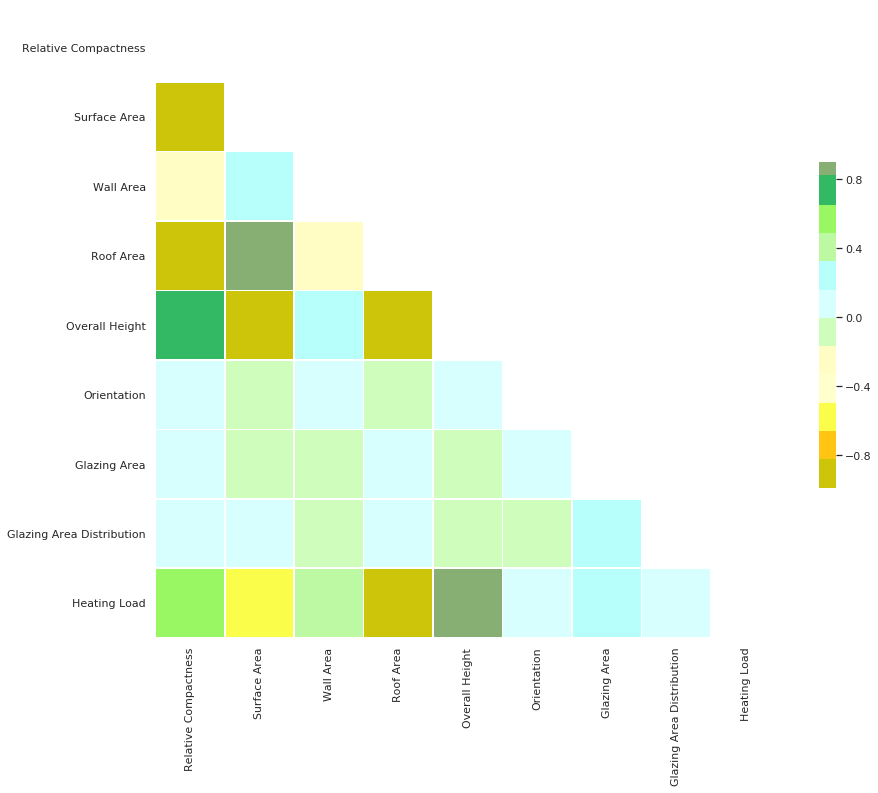

In [241]:
from string import ascii_letters

sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,12))

colors = ['dirty yellow','sunflower','banana yellow','ecru','egg shell','ice blue','pale cyan','very pale green','tea green','light grass green','cool green','sage']

cmap = sns.xkcd_palette(colors)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("relavant matrix.png")

In [247]:
corr = train.corr()
corr.style.background_gradient(cmap='Pastel1').set_precision(3)
# plt.savefig
# plt.savefig("coeficient matrix.png")
# plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
Relative Compactness,1,-0.992,-0.215,-0.874,0.825,0.0133,0.0121,0.00604,0.615
Surface Area,-0.992,1,0.204,0.887,-0.86,-0.0119,-0.0148,0.00115,-0.657
Wall Area,-0.215,0.204,1,-0.271,0.263,0.0147,-0.0558,-0.0175,0.437
Roof Area,-0.874,0.887,-0.271,1,-0.969,-0.0186,0.0118,0.00935,-0.851
Overall Height,0.825,-0.86,0.263,-0.969,1,0.0214,-0.0153,-0.0216,0.883
Orientation,0.0133,-0.0119,0.0147,-0.0186,0.0214,1,0.0724,-0.0144,0.0266
Glazing Area,0.0121,-0.0148,-0.0558,0.0118,-0.0153,0.0724,1,0.256,0.257
Glazing Area Distribution,0.00604,0.00115,-0.0175,0.00935,-0.0216,-0.0144,0.256,1,0.0656
Heating Load,0.615,-0.657,0.437,-0.851,0.883,0.0266,0.257,0.0656,1


In [230]:
train.T.iloc[0].name

'Relative Compactness'

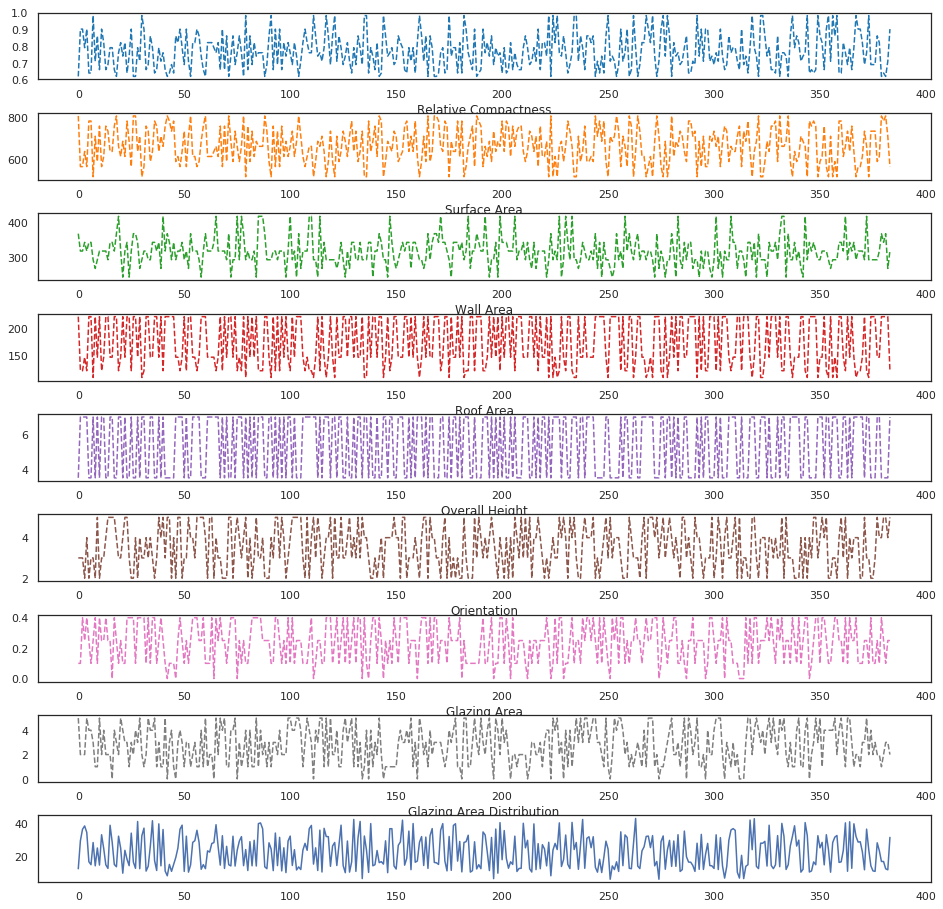

In [237]:
fig, axs = plt.subplots(9,1, figsize=(16, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
         'darker blue']

axs = axs.ravel()

for i in range(8):

    axs[i].plot(train.iloc[:,i], "--", color=colors[i])
#     axs.set_xlabel('{}'.format(train[i].name))
#     print("general category for: ",'{category}'.format(category = combine_category[i].name))
#     axs[i].plot(y_train)
    axs[i].set_xlabel(train.T.iloc[i].name)
axs[8].plot(y_train, "-")
fig.savefig('each column curve.png')

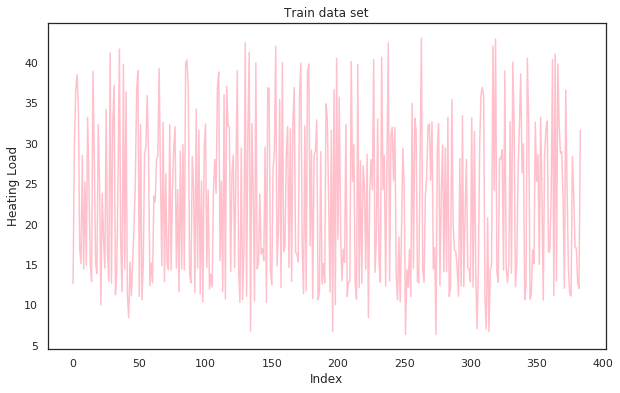

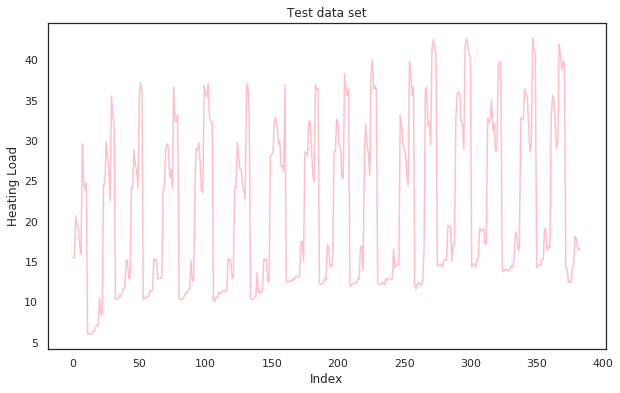

In [250]:
# plot train data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_train)), y_train, c = 'pink')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Train data set')
plt.show()

# plot test data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_test)), y_test, c = 'pink')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Test data set')
plt.show()

## Least-Squares Linear Model

In [450]:
def get_PHI(x):
    bias = np.ones(len(x)).reshape(len(x), 1)
    PHI = np.concatenate((bias,x), axis=1)
    return PHI
 
# define a function used to get the root mean squared error
def get_rms(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    err = np.sqrt(np.mean((y-y_pred)**2))
    return err

In [598]:
x_train = np.array(train.iloc[:,:8]).astype(float)
y_train = np.array(train.T.iloc[-1]).astype(float)
x_test = np.array(test.iloc[:,:-1]).astype(float)
y_test = np.array(train.T.iloc[-1]).astype(float)

Normalize the Data

In [599]:
# Normalize train and test data
x_train = (x_train - np.mean(x_train)) / np.std(x_train)
x_test = (x_test - np.mean(x_test)) / np.std(x_test)

Add bias as 1

In [600]:
x_train = get_PHI(x_train)
x_test = get_PHI(x_test)

In [637]:
nlam = [0, 0.01, 10]
for lam in nlam:
    train_w = np.linalg.inv(x_train.T @ x_train + lam * np.eye(9)) @ x_train.T @ y_train 
    test_w = np.linalg.inv(x_test.T @ x_test + lam * np.eye(9)) @ x_test.T @ y_test 
    
    train_prediction = x_train @ train_w
    test_prediction = x_test @ test_w
    print('lam =', lam)
    print('RMS on train data set is', get_rms(y_train, train_prediction))
    print('RMS on test data set is', get_rms(y_test, test_prediction))
    print(' ')

lam = 0
RMS on train data set is 182.61972965130934
RMS on test data set is 13.408348475560757
 
lam = 0.01
RMS on train data set is 4.662314793844922
RMS on test data set is 10.002462005528029
 
lam = 10
RMS on train data set is 5.411766338987963
RMS on test data set is 10.075919940242322
 


# Task 2 - Bayesian Linear Regression


Apply the standard Bayesian linear regression model, using Type-II maximum likelihood to estimate “most probable” values for hyperparameter 𝛼 and noise variance $𝜎^{2}$.

In [273]:
def compute_posterior(PHI, t, alph, s2):
    M = PHI.shape[1]
    lam = alph * s2
    H = (PHI.T @ PHI) + lam * np.eye(M)
    Mu = (((np.linalg.inv(H)@ PHI.T) @ t))
    SIGMA = s2 * np.linalg.inv(H)
    return Mu, SIGMA

In [353]:
def compute_log_marginal(PHI, t, alph, s2):
    #
    N, M = PHI.shape
    beta = 1 / s2
    Mu, SIGMA = compute_posterior(PHI, t, alph, s2)

    logML = -N * np.log(2 * np.pi)
    #
    sgn, logdet = np.linalg.slogdet(SIGMA)
    #
    if sgn < 0:
        print("Error with alpha={0}, s2={1}".format(alph, s2))
        raise np.linalg.LinAlgError("logdet sign is negative - something is wrong!")
    #
    logML += logdet + N*np.log(beta) + M*np.log(alph)
    #
    logML -= beta * (t.T @ (t - PHI @ Mu))
    logML = logML / 4.0
    #
    return logML

In [693]:
log_alph = np.linspace(-20,-11,100)
log_s2 = np.linspace(1.95, 2.6,100)

alph_ = np.exp(log_alph)
s2_ = np.exp(log_s2)

In [694]:
max_alph = 0
max_s2 = 0
max_lgp = np.inf
log_pdf =[]

for alph, s2 in itertools.product(alph_,s2_):
    neg_lgp = compute_log_marginal(x_train, y_train,alph, s2)
    log_pdf.append(neg_lgp)

In [695]:
contour_lgb = np.reshape(log_pdf,(100,100)).T
contour_pdf = np.exp(contour_lgb/1.5)

In [711]:
max_logpdf=contour_lgb.max()
max_pdf = contour_pdf.max()
index_alph, index_r= np.where(contour_pdf==max_pdf)

print(index_alph, index_r)

[45] [45]


In [712]:
max_loga = log_alph[45]
max_logs = log_s2[45]

In [727]:
print('best alph:      ',max_loga)
print('best covariance:',max_logs)
print('best log pdf:   ',max_logpdf)
print('best pdf:   ',max_pdf)

best alph:       -15.90909090909091
best covariance: 2.2454545454545456
best log pdf:    -509.0869331007872
best pdf:    4.020092970126485e-148


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


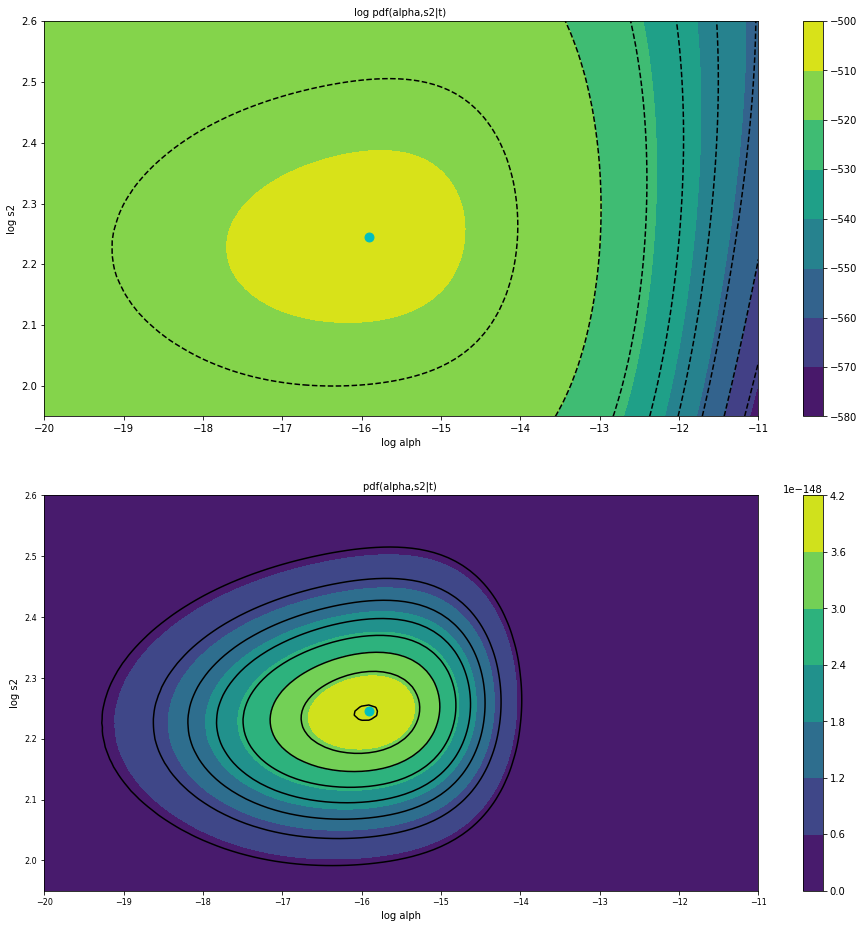

In [722]:
plt.figure(figsize=(16,16))

X, Y = np.meshgrid(log_alph, log_s2)
Z1 = contour_lgb
Z2 = contour_pdf

plt.subplot(211)
plt.contour(X, Y, Z1, 8, colors='black', linewidth=2)
plt.title('log pdf(alpha,s2|t) ',fontsize=10)
plt.xlabel('log alph',fontsize=10)
plt.ylabel('log s2',fontsize=10)


cp = plt.contourf(X, Y, Z1)
plt.colorbar(cp)
plt.scatter(max_loga,max_logs,color='c', s=80)
plt.subplot(212)
plt.contour(X, Y, Z2, 8, colors='black', linewidth=4)
plt.title('pdf(alpha,s2|t) ',fontsize=10)
plt.xlabel('log alph',fontsize=10)
plt.ylabel('log s2',fontsize=10)

cp = plt.contourf(X, Y, Z2)
plt.colorbar(cp)
plt.scatter(max_loga,max_logs,color='c', s=80)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig('alph sigma contour pdf and lgp.png')
plt.show()

In [ ]:
def get_accuracy(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    SS_tot = ((y - y.mean()) ** 2).sum()
    SS_res = ((y - y_pred) ** 2).sum()
    accuracy = np.absolute(1 - SS_res / SS_tot)
    return accuracy

In [453]:
Mu, SIGMA = compute_posterior(x_train, y_train,alph, s2)
train_predict = x_train @ Mu
test_predict = x_test @ Mu

print('accuracy on train data set is', get_accuracy(y_train, train_predict)*100, '%')
print('accuracy on test data set is', get_accuracy(y_test, test_predict)*100, '%')

print('train data rms is', get_rms(y_train, train_predict))
print('test data rms is', get_rms(y_test, test_predict))


accuracy on train data set is 86.8735218424988 %
accuracy on test data set is 92.10122959363896 %
train data rms is 3.6422444217310774
test data rms is 13.933494453621748


# Task 3 - Hamiltonian Monte Carlo(HMC) Sampling Algorithm

The Hamiltonian Monte Carlo (HMC) algorithm for Bayesian inference, initially verifying the HMC implementation on a simple Gaussian example.

#### Test the HMC implementation on the Correlated Gaussian

In [728]:
def e_func(x):
    rho = 1/1.0625
    p0 = np.log(1/2*np.pi*1.0625*1.0625*np.sqrt(1-rho**2))
    p1 = ((x[0]-1)**2-2*rho*(x[0]-1)*(x[1]-1)+(x[1]-1)**2)/(1.0625*2*(1-rho**2))
    lgp = p0 - p1
    
    return -lgp

In [729]:
def e_grad(x):
    rho = 1/1.0625
    g = np.empty(2) 
    g[0] = (2*(x[0]-1)-2*rho*(x[1]-1))/(1.0625*2*(1-rho**2))
    g[1] = (2*(x[1]-1)-2*rho*(x[0]-1))/(1.0625*2*(1-rho**2))
    return g    

10000


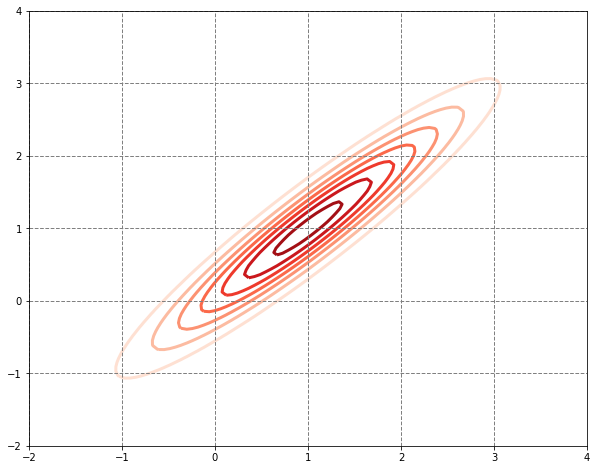

In [737]:
f = 5  # The "frequency" argument for the energy, used here to demonstrate use of "args"
# Plotting parameters
fsz = (10,8)
gsz = 100
lim = 4
#
gx = np.linspace(-2, 4, gsz)
GX, GY = np.meshgrid(gx, gx)
print(GX.size)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))
#
plt.figure(figsize=fsz)
P = np.asarray([np.exp(-e_func(g)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);
plt.grid(True, linestyle = "--", color = "gray", linewidth = "1")
plt.savefig('task 3-1')

In [738]:
#
# Initial state: something random and sensible
np.random.seed(seed=1)  # For reproducibility
x0 = np.random.normal(size=2)
x0.copy()
hmc.gradient_check(x0, e_func, e_grad)

Calc.         Numeric       Delta         Acc.
     17.6494       17.6494  -5.142233e-10  11
    -18.1282      -18.1282  -2.039187e-09  10


In [739]:
args = [x_train, y_train]
len(args[0])

384

|----------|  0% accepted [ 4 secs to go ]
|#---------| 90% accepted [ 3 secs to go ]
|##--------| 90% accepted [ 3 secs to go ]
|###-------| 90% accepted [ 2 secs to go ]
|####------| 90% accepted [ 2 secs to go ]
|#####-----| 90% accepted [ 2 secs to go ]
|######----| 90% accepted [ 1 secs to go ]
|#######---| 90% accepted [ 1 secs to go ]
|########--| 90% accepted [ 1 secs to go ]
|#########-| 90% accepted [ 0 secs to go ]
|##########| 91% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 / eps=0.3 / Accept=90.6%


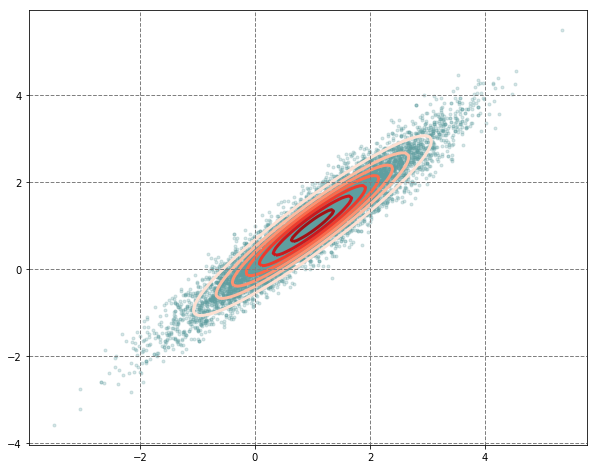

In [741]:
#
np.random.seed(seed=1)  # For reproducibility
R = 10000  # More than really needed, but produces a nice dense plot
burn = int(R/10)  # A reasonable rule-of-thumb
L = 25  # OK here (should be larger in regression sampling)
eps = 0.3  # Trial-and-error ... feel free to experiment!
#
S, *_ = hmc.sample(x0, e_func, e_grad, R, L, eps, burn=burn, checkgrad=False, args=[])
#
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);
plt.grid(True, linestyle = "--", color = "gray", linewidth = "1")
plt.savefig('task 3-2')

In [742]:
AVE_1 = []
AVE_2 = []
mu_1 = []
mu_2 = []
# for i, val in enumerate(S):
    
for i in range (len(S.T[0])):
    AVE_1.append(S.T[0][i])
    AVE_2.append(S.T[1][i])
    average_1 = np.mean(AVE_1)
    average_2 = np.mean(AVE_2)
    mu_1.append(average_1)
    mu_2.append(average_2)

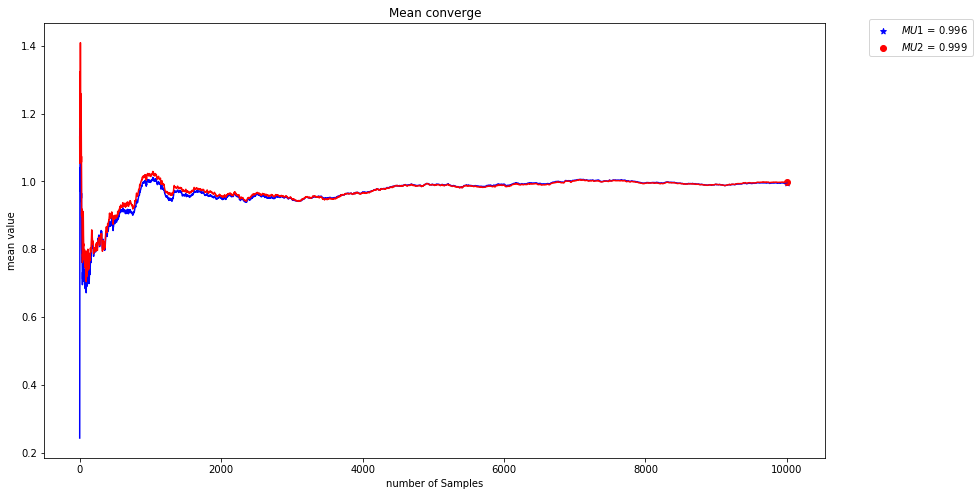

In [752]:
plt.figure( figsize=(14, 8))
plt.plot(mu_1,'b')
plt.scatter(len(mu_1), mu_1[-1], c = 'b',marker='*', label = '$MU1$ = %0.3f' % mu_1[-1])
plt.plot(mu_2,'r')
plt.scatter(len(mu_2), mu_2[-1], c = 'r',marker='o', label = '$MU2$ = %0.3f' % mu_2[-1])

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.02))
plt.title('Mean converge')
plt.xlabel('number of Samples')
plt.ylabel('mean value')
plt.savefig("Task3 two mean converge.png")
plt.show()

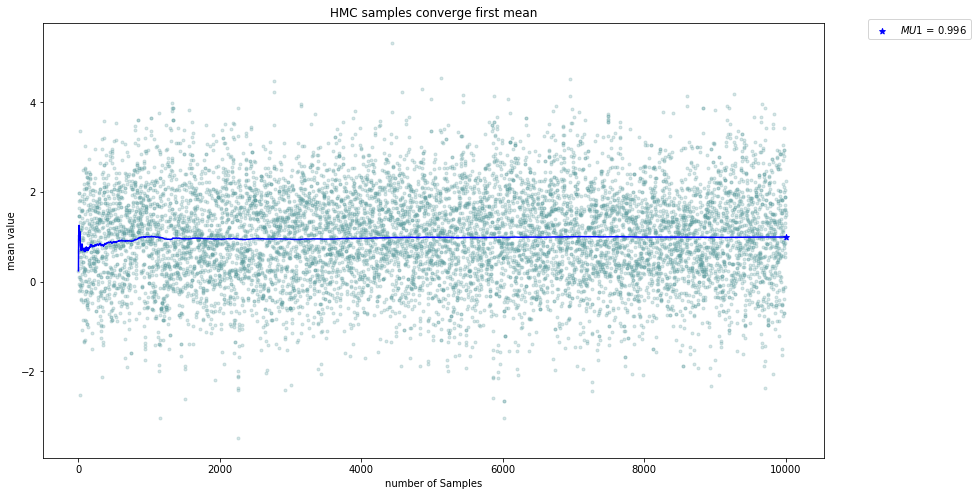

In [764]:
plt.figure( figsize=(14, 8))
plt.plot(mu_1,'b')
plt.scatter(len(mu_1), mu_1[-1], c = 'b',marker='*', label = '$MU1$ = %0.3f' % mu_1[-1])
plt.plot(S[:, 0], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.02))
plt.title('HMC samples converge first mean')
plt.xlabel('number of Samples')
plt.ylabel('mean value')
# plt.savefig("Task3 two mean converge.png")
plt.show()

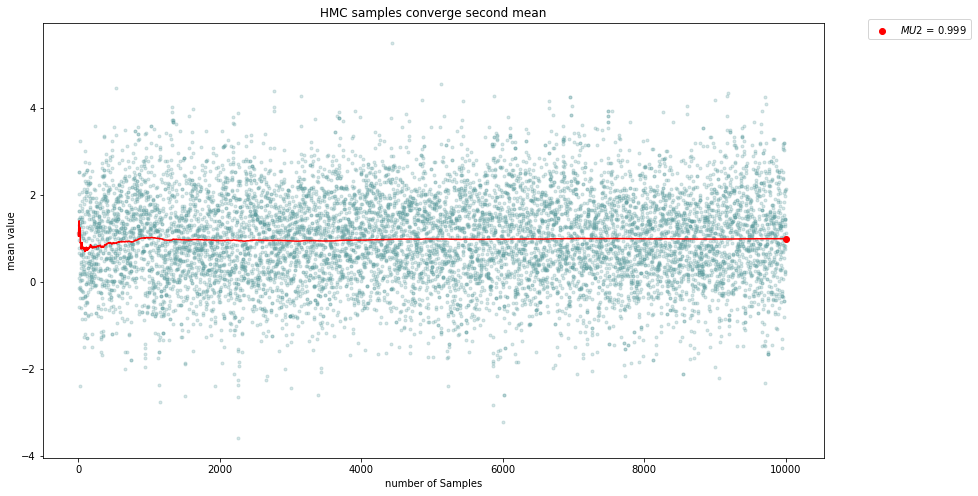

In [762]:
plt.figure( figsize=(14, 8))
plt.plot(mu_2,'r')
plt.scatter(len(mu_2), mu_2[-1], c = 'r',marker='o', label = '$MU2$ = %0.3f' % mu_2[-1])

plt.plot(S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.02))
plt.title('HMC samples converge second mean')
plt.xlabel('number of Samples')
plt.ylabel('mean value')
# plt.savefig("Task3 two mean converge.png")
plt.show()

In [744]:
cov_1 = []
cov_2 = []
c_11 = []
c_22 = []
c_12 = []

for i in range (len(S.T[0])):
    cov_1.append(S.T[0][i])
    cov_2.append(S.T[1][i])
    variance_1 = np.mean(np.square(cov_1)) - np.mean(cov_1)**2
    variance_2 = np.mean(np.square(cov_2)) - np.mean(cov_2)**2
    variance_12 = np.mean(np.multiply(cov_1,cov_2)) - np.mean(cov_1) * np.mean(cov_2)
    c_11.append(variance_1)
    c_22.append(variance_2)
    c_12.append(variance_12)

In [766]:
S.T[1]

array([1.13143083, 0.97592348, 1.44393746, ..., 1.98429467, 1.12492573,
       2.15106686])

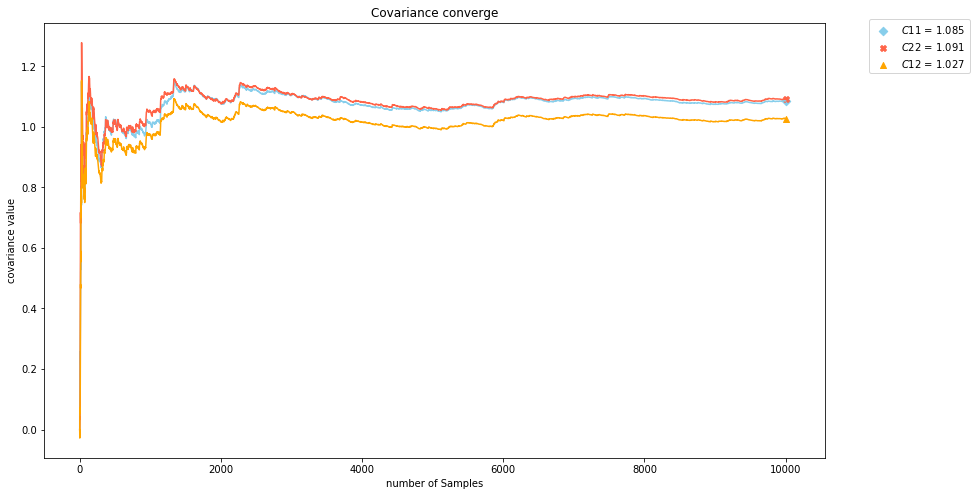

In [753]:
plt.figure( figsize=(14, 8))
plt.plot(c_11,'skyblue')
plt.scatter(len(c_11),c_11[-1], c = 'skyblue',marker='D', label = '$C11$ = %0.3f' % c_11[-1])
plt.plot(c_22,'tomato')
plt.scatter(len(c_22),c_22[-1], c = 'tomato',marker='X', label = '$C22$ = %0.3f' % c_22[-1])
plt.plot(c_12,'orange')
plt.scatter(len(c_12),c_12[-1], c = 'orange',marker='^', label = '$C12$ = %0.3f' % c_12[-1])

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.02))
plt.title('Covariance converge')
plt.xlabel('number of Samples')
plt.ylabel('covariance value')
plt.savefig("Task3 three covariance converge.png")
plt.show()

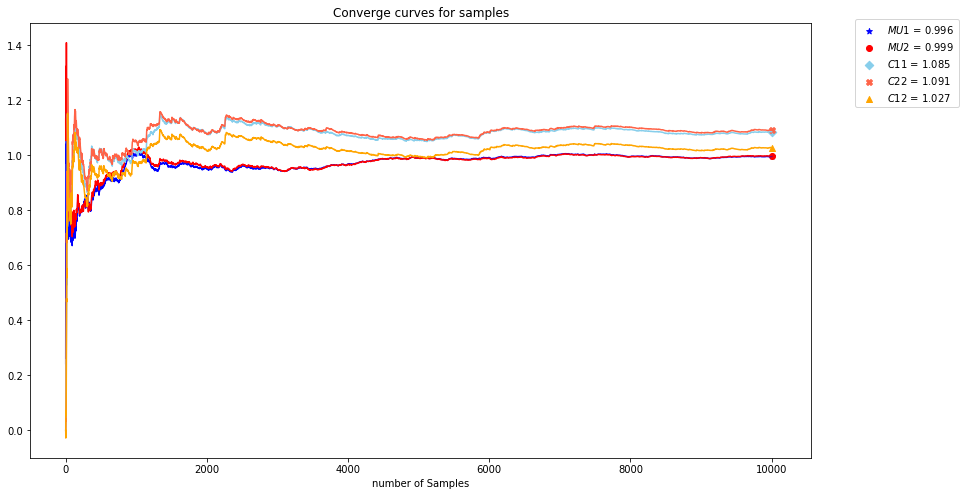

In [763]:
plt.figure( figsize=(14, 8))
plt.plot(mu_1,'b')
plt.scatter(len(mu_1), mu_1[-1], c = 'b',marker='*', label = '$MU1$ = %0.3f' % mu_1[-1])
plt.plot(mu_2,'r')
plt.scatter(len(mu_2), mu_2[-1], c = 'r',marker='o', label = '$MU2$ = %0.3f' % mu_2[-1])


plt.plot(c_11,'skyblue')
plt.scatter(len(c_11),c_11[-1], c = 'skyblue',marker='D', label = '$C11$ = %0.3f' % c_11[-1])
plt.plot(c_22,'tomato')
plt.scatter(len(c_22),c_22[-1], c = 'tomato',marker='X', label = '$C22$ = %0.3f' % c_22[-1])
plt.plot(c_12,'orange')
plt.scatter(len(c_12),c_12[-1], c = 'orange',marker='^', label = '$C12$ = %0.3f' % c_12[-1])

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.02))
plt.title('Converge curves for samples')
plt.xlabel('number of Samples')

plt.savefig("Task3 five.png")
plt.show()

# Task 4 - Apply HMC to the Linear Regression Model


Apply HMC to obtain samples from the joint posterior over weights, hyperparameter 𝛼 and noise variance $𝜎^{2}$ for the linear regression model on the energy efficiency training data.

In [767]:
def e_func(x, f):
    
    PHI=f[0]
    t=f[1]
    
    weight=x[0:9]
    alph=np.exp(x[9])
    s2=np.exp(x[10])
    
    N,M=PHI.shape
    p0 = - N/2*(np.log(2 * np.pi * s2)) -  sum(( t- weight@PHI.T)**2) / (2*s2)
    p1 = M/2 * np.log(alph /(2 * np.pi)) - sum( weight**2) * alph/ 2    
    lgp = p0 + p1
                
    return -lgp

In [768]:
def e_grad(x, f):
    PHI=f[0]
    t=f[1]
    N,M=PHI.shape
    weight=x[0:9]
    alph=np.exp(x[9])
    s2=np.exp(x[10])
    
    g = np.empty(11)
    
    g[0:9] = -PHI.T@(t- PHI @ weight) / s2 + alph * weight
    g[9]=-M/2 +alph/2 * sum(weight **2)
    g[10]= N/2 -1/(2*s2)*sum((t-weight@ PHI.T)**2)   
    return g

In [771]:
f=[x_train,y_train]

np.random.seed(seed=1)  # For reproducibility
x=np.random.rand(11)
# x = np.random.normal(size=11)
x.copy()

# x=np.random.rand(11)
hmc.gradient_check(x,e_func,e_grad,f)

Calc.         Numeric       Delta         Acc.
    -5898.74      -5898.74  -8.464176e-06   9
     3769.92       3769.92  -2.703654e-06  10
    -12806.1      -12806.1  -1.043618e-05  10
     -4654.2       -4654.2   2.276683e-05   9
    -286.048      -286.048   2.160463e-05   8
     3633.08       3633.08  -5.549604e-05   8
     3697.79       3697.79   1.985635e-05   9
     3783.47       3783.47  -3.810124e-05   8
     3716.83       3716.83  -1.650309e-05   9
    -3.53523      -3.53523  -2.521734e-06   7
      -81481        -81481   1.366556e-06  11


Calc.         Numeric       Delta         Acc.
    -1153.56      -1153.56  -4.505101e-06   9
      736.92        736.92  -6.643539e-06   9
    -2499.78      -2499.78   6.488830e-06   9
    -915.563      -915.563  -2.415369e-06   9
     -51.114       -51.114  -1.161576e-05   7
     710.149       710.149  -7.657905e-06   8
      723.04        723.04   8.293945e-06   8
     739.693       739.693   8.124841e-06   8
     726.658       726.658   7.761383e-06   8
    -4.36983      -4.36983  -2.653117e-08   9
    -15298.9      -15298.9   1.304361e-07  12
|----------|  0% accepted [ 24 secs to go ]
|#---------| 99% accepted [ 22 secs to go ]
|##--------| 99% accepted [ 19 secs to go ]
|###-------| 99% accepted [ 17 secs to go ]
|####------| 99% accepted [ 15 secs to go ]
|#####-----| 99% accepted [ 12 secs to go ]
|######----| 99% accepted [ 10 secs to go ]
|#######---| 99% accepted [ 7 secs to go ]
|########--| 99% accepted [ 5 secs to go ]
|#########-| 99% accepted [ 2 secs to go ]
|#########

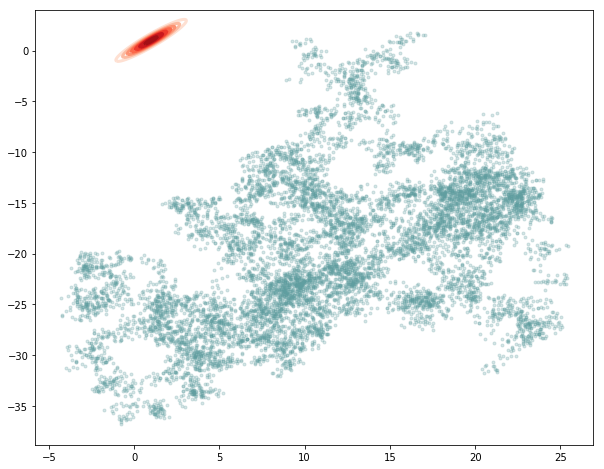

In [799]:
np.random.seed(seed=1)  # For reproducibility
x=np.random.normal(size=9)
logalpha=[-4]
log_s2=[2]
x = np.concatenate((x,logalpha,log_s2))

R = 10000  # More than really needed, but produces a nice dense plot
burn = int(R/10)  # A reasonable rule-of-thumb
L = 20  # OK here (should be larger in regression sampling)
eps = 0.0175  # Trial-and-error ... feel free to experiment!
#
S, *_ = hmc.sample(x, e_func, e_grad, R, L, eps, burn=burn, checkgrad=True, args=[f])
#
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [821]:
S.shape

(10000, 11)

Text(0.5, 1.0, 'A histogram of log alpha values')

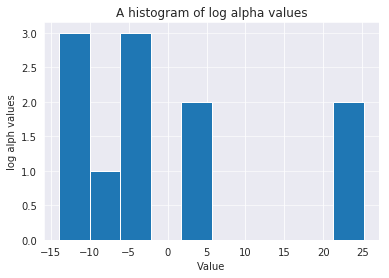

In [831]:
plt.hist(S[9])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('log alph values')
plt.title("A histogram of log alpha values")

In [842]:
np.exp([1,2])

array([2.71828183, 7.3890561 ])

Text(0.5, 0, 'sigma ')

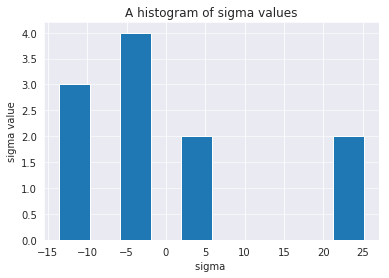

In [844]:
sgima_v = np.sqrt(np.exp(S[10]))

plt.hist(S[10])  # arguments are passed to np.histogram
plt.grid(axis='y', alpha=0.75)

plt.ylabel('sigma value')

plt.title("A histogram of sigma values")
plt.xlabel('sigma ')

In [846]:
expect_sigma = np.mean(sgima_v)
expect_sigma

32248.734687244345

In [780]:
HMC_w  = np.mean(S.T[0:9],axis =1)

In [783]:
HMC_trainp = x_train @ HMC_w
HMC_testp = x_test @ HMC_w

In [784]:
print('train data rms is', get_rms(y_train, HMC_trainp))
print('test data rms is', get_rms(y_test, HMC_testp))

train data rms is 4.791655924628543
test data rms is 13.759834190848146


# Task 5 - Incorporate Automatic Relevance Determination (ARD)


Estimate which are the (most) relevant input variables by modifying your HMC-based approach to include an *automatic relevance determination* (ARD) prior.

In [852]:
def e_grad(x, f):
    PHI=f[0]
    t=f[1]
    N,M=PHI.shape
    weight=x[0:9]
    alph=np.exp(x[9:18])
    s2=np.exp(x[18])
    
    g = np.empty(19)
    
    g[0:9] = -PHI.T @ (t- PHI @ weight) / s2 + alph * weight
    g[9:18]= -1/2 +(alph * ( weight **2) )/2

    g[18] = N/2 -1/(2*s2)*sum((t-weight@ PHI.T)**2)   

    return g

In [853]:
def e_func(x, f):
    PHI=f[0]
    t=f[1]
    N,M=PHI.shape
    weight=x[0:9]
    alph=np.exp(x[9:18])
    s2=np.exp(x[18])
    
    p0 = - N/2*(np.log(2 * np.pi * s2)) - sum(( t- weight@PHI.T)**2) / (2*s2)
    p1 = np.sum(1/2 *np.log(alph/(2* np.pi))-alph*(weight**2)/2)
    
    lgp = p0 + p1
                
    return -lgp

In [864]:
np.random.seed(seed=7)  # For reproducibility
# x=np.random.rand(9)
x=np.random.normal(size=9)

logalpha=[-4]*9
log_s2=[2]
x = np.concatenate((x,logalpha,log_s2))

x.copy()

hmc.gradient_check(x,e_func,e_grad,f)

Calc.         Numeric       Delta         Acc.
    -1047.76      -1047.76   1.303240e-05   8
     669.326       669.326  -4.316702e-07  10
    -2259.12      -2259.12  -3.622442e-06   9
    -831.749      -831.749   1.152542e-06   9
    -40.6666      -40.6666   2.744122e-07   9
     644.821       644.821  -2.063416e-06   9
     656.695       656.695   4.269709e-06   9
     671.829       671.829  -9.915065e-06   8
     660.007       660.007   4.076791e-07  10
   -0.473828     -0.473829  -4.727113e-07   7
   -0.498012     -0.498012  -1.547771e-07   7
    -0.49999      -0.49999  -2.929174e-08   8
   -0.498479     -0.498479  -3.288142e-07   7
     -0.4943       -0.4943  -1.886281e-07   7
        -0.5          -0.5  -2.083406e-07   7
        -0.5          -0.5  -1.765281e-07   7
   -0.471803     -0.471802   3.528177e-07   7
   -0.490516     -0.490516  -5.107278e-08   7
    -12915.8      -12915.8  -7.198196e-07  11


Calc.         Numeric       Delta         Acc.
    -1047.76      -1047.76   1.303240e-05   8
     669.326       669.326  -4.316702e-07  10
    -2259.12      -2259.12  -3.622442e-06   9
    -831.749      -831.749   1.152542e-06   9
    -40.6666      -40.6666   2.744122e-07   9
     644.821       644.821  -2.063416e-06   9
     656.695       656.695   4.269709e-06   9
     671.829       671.829  -9.915065e-06   8
     660.007       660.007   4.076791e-07  10
   -0.473828     -0.473829  -4.727113e-07   7
   -0.498012     -0.498012  -1.547771e-07   7
    -0.49999      -0.49999  -2.929174e-08   8
   -0.498479     -0.498479  -3.288142e-07   7
     -0.4943       -0.4943  -1.886281e-07   7
        -0.5          -0.5  -2.083406e-07   7
        -0.5          -0.5  -1.765281e-07   7
   -0.471803     -0.471802   3.528177e-07   7
   -0.490516     -0.490516  -5.107278e-08   7
    -12915.8      -12915.8  -7.198196e-07  11
|----------|  0% accepted [ 25 secs to go ]
|#---------| 100% accepted [ 22 sec

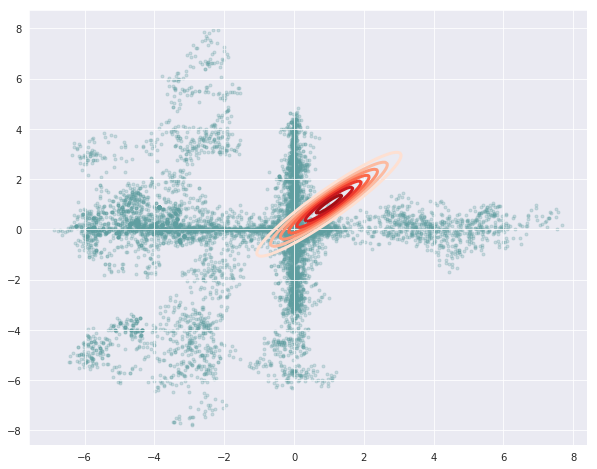

In [868]:
np.random.seed(seed=7)  # For reproducibility
# x=np.random.rand(9)
x=np.random.normal(size=9)

logalpha=[-4]*9
log_s2=[2]
x = np.concatenate((x,logalpha,log_s2))

R = 10000  # More than really needed, but produces a nice dense plot
burn = int(R/10)  # A reasonable rule-of-thumb
L = 20  # OK here (should be larger in regression sampling)
eps = 0.01  # Trial-and-error ... feel free to experiment!
#
S, *_ = hmc.sample(x, e_func, e_grad, R, L, eps, burn=burn, checkgrad=True, args=[f])
#
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [ ]:
logalph_expect = np.me

In [ ]:
plt.hist(S[9])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('log alph values')
plt.title("A histogram of log alpha values")

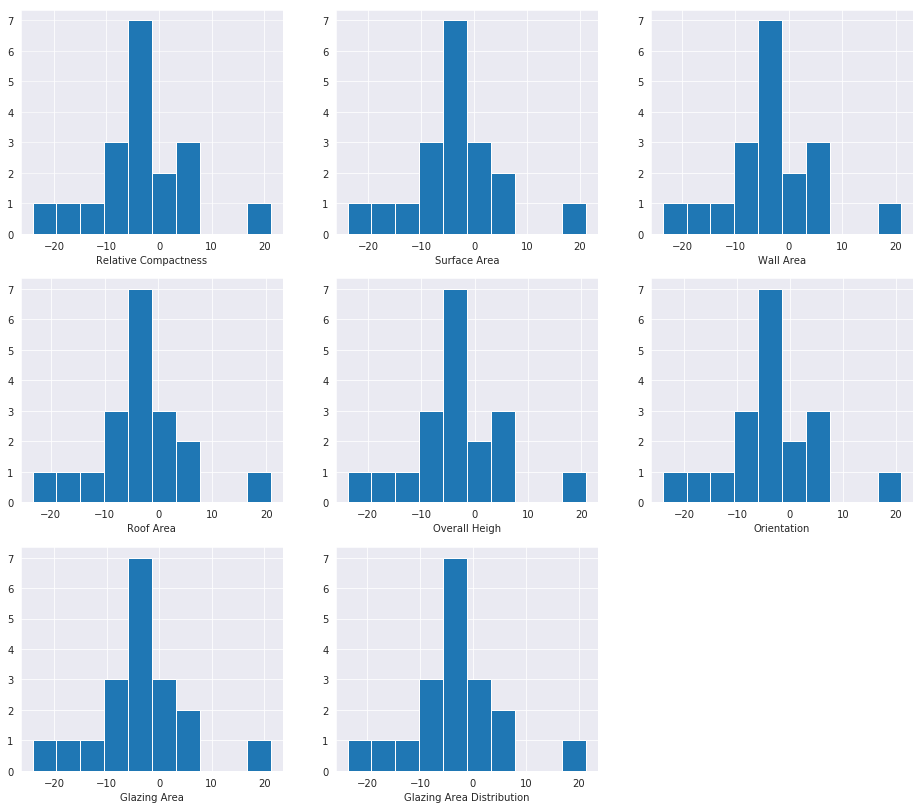

In [891]:
plt.figure( figsize=(16, 14))

plt.title("A histogram of log alpha values")

plt.subplot(3,3,1)
plt.hist(S[8])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Relative Compactness')

plt.subplot(3,3,2)
plt.hist(S[9])
plt.xlabel('Surface Area')
plt.subplot(3,3,3)
plt.hist(S[10])
plt.xlabel('Wall Area')

plt.subplot(3,3,4)
plt.hist(S[11])
plt.xlabel('Roof Area')

plt.subplot(3,3,5)
plt.hist(S[12])
plt.xlabel('Overall Heigh')


plt.subplot(3,3,6)
plt.hist(S[13])
plt.xlabel('Orientation')


plt.subplot(3,3,7)
plt.hist(S[14])
plt.xlabel('Glazing Area')


plt.subplot(3,3,8)
plt.hist(S[16])
plt.xlabel('Glazing Area Distribution')
plt.savefig("5 alpha for variable.png")


In [893]:
logalph_expect = np.mean(S[9:18],axis =1)
logalph_expect

array([-3.70649249, -3.74851144, -3.71676062, -3.75447424, -3.78911721,
       -3.78882495, -3.76884465, -3.77655095, -3.76938419])

In [898]:
squared_w = np.square(S[0:9])
squared_wexp = np.mean(squared_w,axis =1)
squared_wexp

array([ 99.3233655 , 100.30653742, 100.37785156, 101.42830669,
       100.97174882, 101.98387488, 100.61393099, 100.40244042,
        99.67687273])

Text(0.5, 0, 'sigma values')

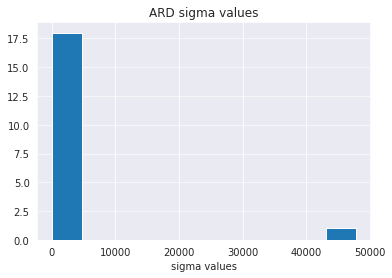

In [911]:
plt.hist(np.sqrt(np.exp(S[18])))
plt.grid(axis='y', alpha=0.75)
plt.title('ARD sigma values')
plt.xlabel('sigma values')

In [910]:
ARD_s_e =np.mean(np.sqrt(np.exp(S[18])))
ARD_s_e

2519.846430855977

In [914]:
ARD_w  = np.mean(S.T[0:9],axis =1)

ARD_trainp = x_train @ ARD_w
ARD_testp = x_test @ ARD_w

print('train data rms is', get_rms(y_train, ARD_trainp))
print('test data rms is', get_rms(y_test, ARD_testp))

train data rms is 4.846760792871463
test data rms is 13.743103219124881


# Task 6 - Experiment with Features

Experiment with introducing some new (non-linear) features to the data, with the aim of improving prediction accuracy.

In [922]:
log_train = np.log(train+1)
exp_train = np.exp(train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [918]:
log_train.shape

(384, 9)

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


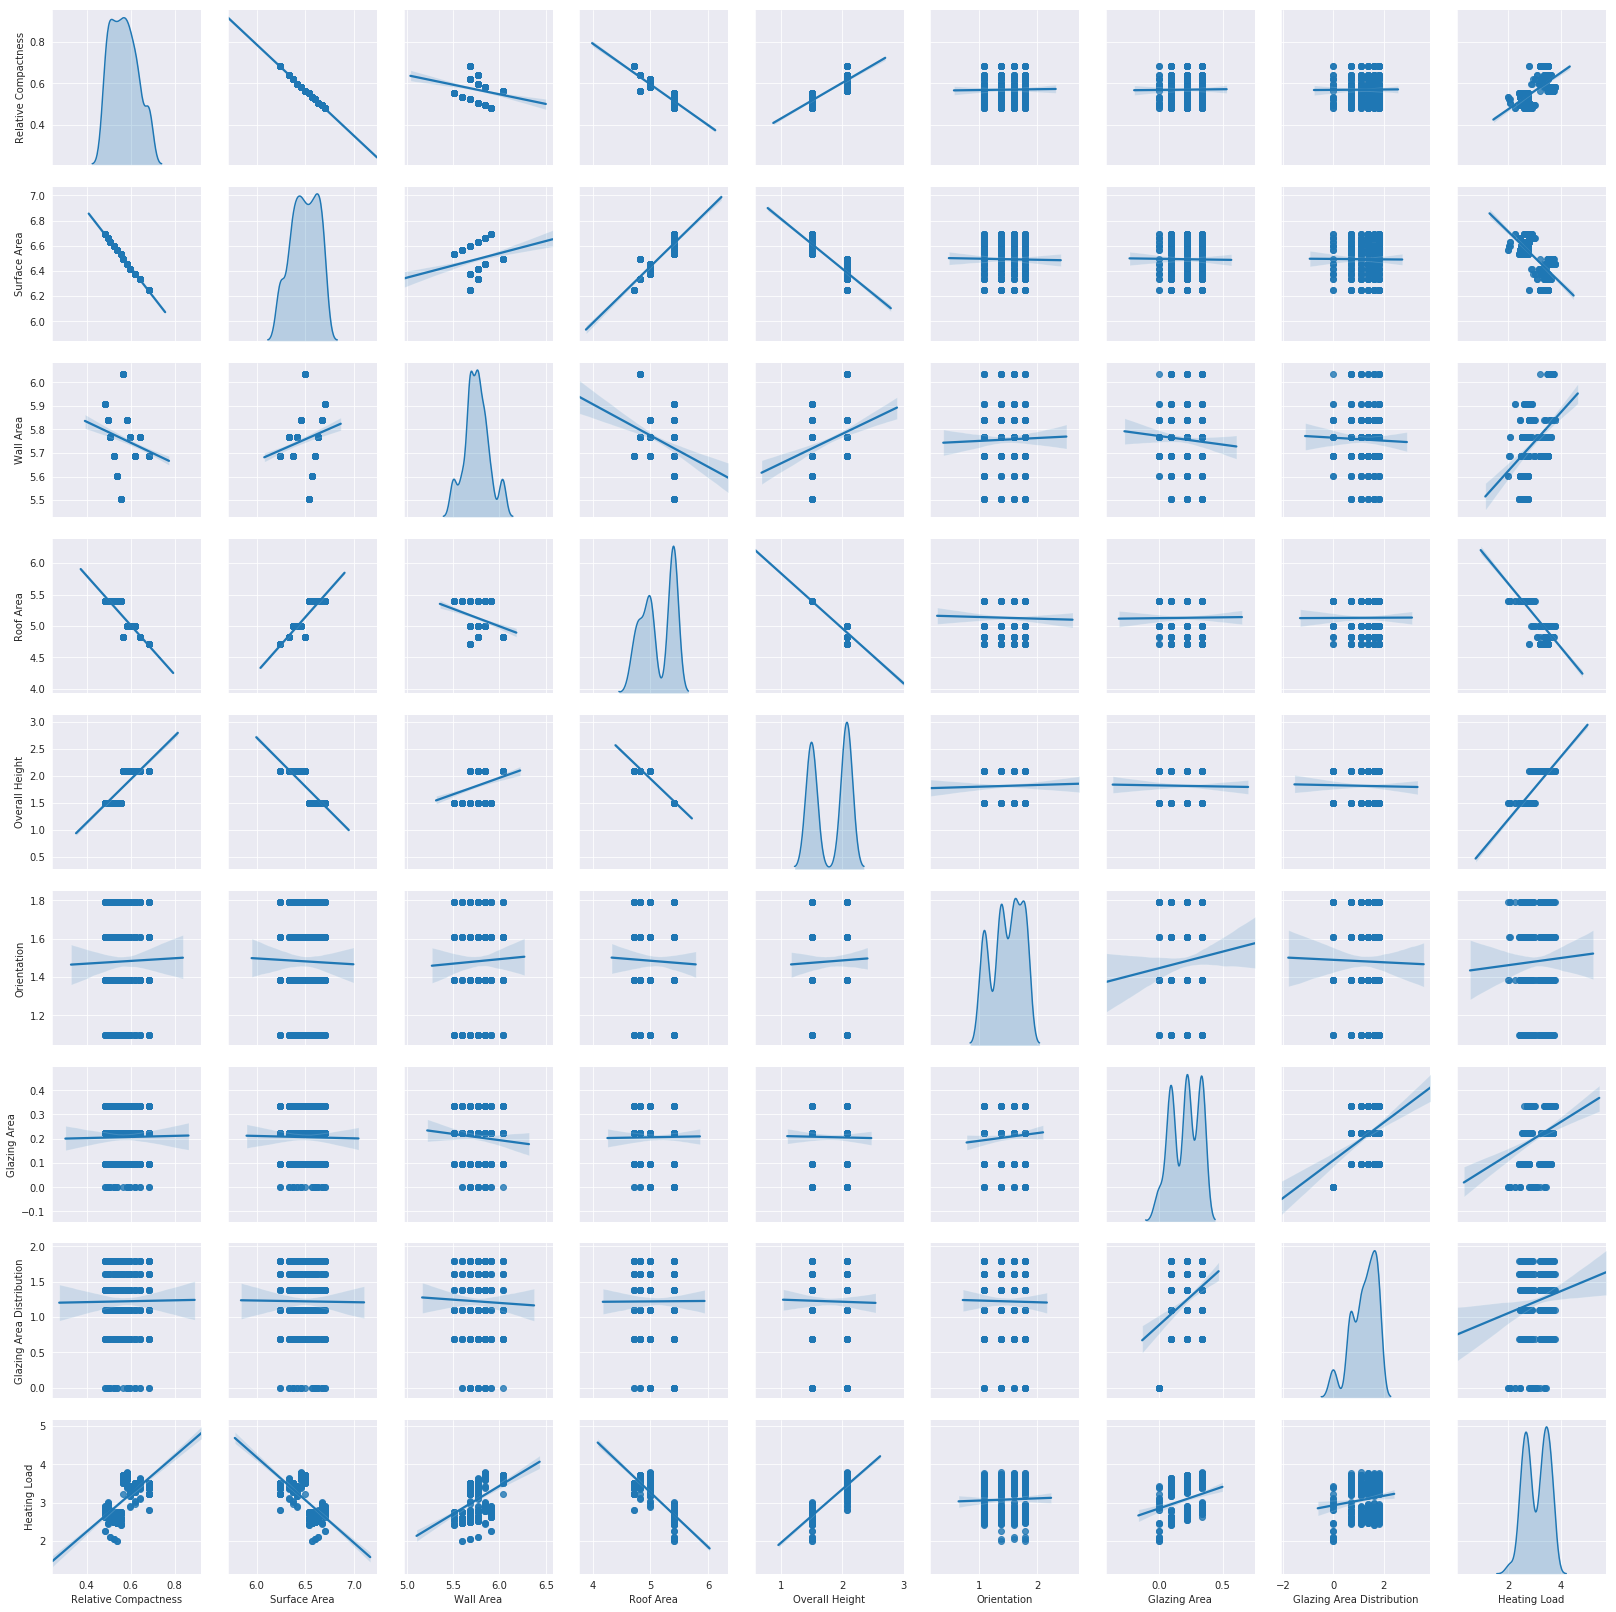

In [923]:
sns.pairplot(log_train, kind="reg",palette="Set2", diag_kind="kde", size=2.5)
plt.savefig("linea relavant matrix.png")

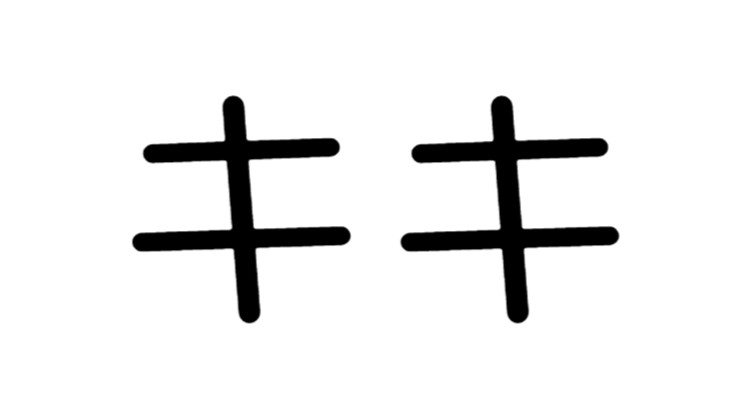

In [12]:
Image(filename='Screenshot 2020-05-21 at 11.39.29.png',width = '100') 